# Case - 成型機PHM,  案例分類 - Trend Analysis

Copyright © 2019 Hsu Shih-Chieh 

分析每一個案例的參數變化趨勢

算法筆記: https://hackmd.io/@JHSU/By3uWuwPH


In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings, matplotlib, datetime
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datasets import load_moldcase
from utils import set_font_cn
from IPython.display import display
from tqdm.notebook import tqdm
from collections import Counter

set_font_cn()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [81]:
data= load_moldcase()
print(data.DESCR)

成型機案例數據
---------------------------

**Data Set Characteristics::**

    :控制器數據: 從控制器取出的螺桿位置, 油壓缸壓力, 料管溫度的數據統計值, 總共有44種數據
    
    :設備健康值數據: 透過高維度SPC監控方法(PCA T2/SPE)計算後的設備健康值, 設備運作時實時運算, 並存入sqlite
    
    :spccol_mapping: PLC數據欄位的中英文對照表
    
    :caseinfo: 每一個案例的詳細資訊



**讀取數據Sample Code**

::
    data= load_moldcase()
    c = data.case01_caseinfo
    df_ctr = data.case01_plc
    df_hv = data.case01_hv


**Model Characteristics**
    
    :設備異常監控: PCA T2/SPE
    
    :設備異常分類(方法一): 案例的參數趨勢分析
        - Source Code: data_molding_TrendAnalysis.ipynb
        - 算法筆記: https://hackmd.io/@JHSU/By3uWuwPH
    

專案說明：
這個專案與控制器廠商合作, 從控制器中取出螺桿位置, 油壓缸壓力, 料管溫度這三項特徵數據, 但因為控制器性能限制, 無法將實時數據取出, 退而求其次, 透過控制器本身的SPC監控功能, 取出這三項特徵的44種統計數據(ex: 最大值, 最小值,...), 並透過這些數據進行設備異常監控與設備異常分類





### Pre-process
- 準備趨勢分析要用的數據, 並根據健康值, 將數據分成defect和ok兩部份
    - 設備健康值數據 - df_hv
    - 控制器數據 - df_ctr
    - 控制器數據(異常事件的區間) - df_ctr_defect
    - 控制器數據(健康值正常的區間) - df_ctr_ok

In [75]:
c = data.case01_caseinfo
df_ctr = data.case01_plc #self.dataAgent.getcontroldata(c.strts, c.endts, c.mid, 'spc')
df_hv = data.case01_hv #self.dataAgent.gethvdata(c.strts, c.endts, c.mid)
df_ctr['dt'] = df_ctr['dt'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
df_hv['is_defect'] =  df_hv['isdefect_clamp'] + df_hv['isdefect_eject'] + df_hv['isdefect_inject'] + df_hv['isdefect_temp']
df_hv['is_defect'] = df_hv['is_defect'].map(lambda x:x>=1)
defectmolds = df_hv[df_hv['is_defect']>=1]['moldidx'].values
df_ctr_defect = df_ctr[df_ctr['SPC_0'].isin(defectmolds)]
df_ctr_defect = df_ctr_defect.loc[c.evt_str:c.evt_end]        
df_ctr_ok = df_ctr[~df_ctr['SPC_0'].isin(defectmolds)]


### 趨勢分析
以下為分析步驟
1. 先計算每個參數的基準(健康數據的中位數)
2. 再計算defect模次每個參數和基準的差距
3. 將上一步計算的差距轉為定性的特徵(變大(差距>0), 變小(差距<0), 不變(差距=0))
4. 匯總每一個參數出現次數最多的特徵
    - 分析結果 - df_devSummary

In [76]:
spc_feature=['SPC_7','SPC_6','SPC_40','SPC_9','SPC_19','SPC_20','SPC_24','SPC_28','SPC_32','SPC_33']
spccol_mapping = data.spccol_mapping

df_ctr_defectDev =df_ctr_defect[spc_feature]-df_ctr_ok[spc_feature].median()
df_ctr_defectDev =df_ctr_defectDev.applymap(lambda x: '變大' if x>0 else '變小' if x!=0 else '不變')

def fn_cnt(col):
    word_counts = Counter(col)
    ret = pd.Series([word_counts['不變'],word_counts['變小'],word_counts['變大']])
    return ret

df_devSummary = df_ctr_defectDev.apply(lambda x: fn_cnt(x))
df_devSummary = df_devSummary.T
df_devSummary.columns=['不變','變小','變大']
summ=df_devSummary.sum(axis=1)
df_devSummary['不變%']=df_devSummary['不變']/summ
df_devSummary['變小%']=df_devSummary['變小']/summ
df_devSummary['變大%']=df_devSummary['變大']/summ

def fn_summary(row):
    tr = np.argmax(row)
    v = str(row[tr]/sum(row)*100)+'%'
    return ' '.join([tr,v])

df_devSummary['summary']=df_devSummary[['不變','變小','變大']].apply(fn_summary, axis=1)
df_devSummary['paraname'] = df_devSummary.index.map(lambda x:spccol_mapping[x])
df_devSummary['trend'] = df_devSummary['summary'].map(lambda x: x.split(' ')[0])
df_devSummary['feature'] = df_devSummary[['paraname', 'trend']].apply(lambda x: ' '.join(x), axis=1)                


### 畫圖
- 畫出每個參數的趨勢圖, 並標註
    - Defect模次 - 紅色
    - 基準線(健康模次的中位數) - 黃色

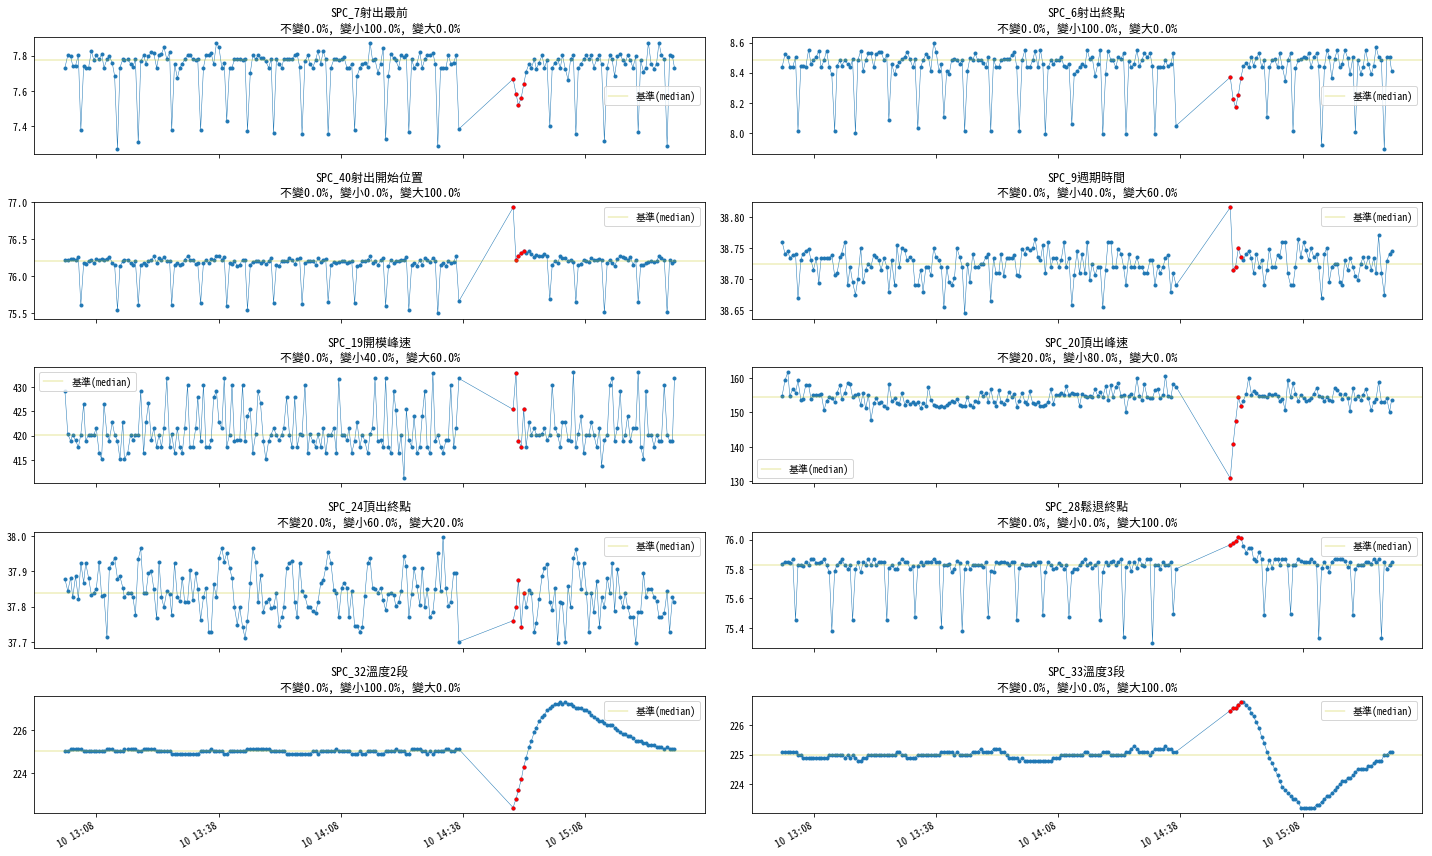

,不變,變小,變大,不變%,變小%,變大%,summary,paraname,trend,feature
SPC_7,0,5,0,0.0,1.0,0.0,變小 100.0%,射出最前,變小,射出最前 變小
SPC_6,0,5,0,0.0,1.0,0.0,變小 100.0%,射出終點,變小,射出終點 變小
SPC_40,0,0,5,0.0,0.0,1.0,變大 100.0%,射出開始位置,變大,射出開始位置 變大
SPC_9,0,2,3,0.0,0.4,0.6,變大 60.0%,週期時間,變大,週期時間 變大
SPC_19,0,2,3,0.0,0.4,0.6,變大 60.0%,開模峰速,變大,開模峰速 變大
SPC_20,1,4,0,0.2,0.8,0.0,變小 80.0%,頂出峰速,變小,頂出峰速 變小
SPC_24,1,3,1,0.2,0.6,0.2,變小 60.0%,頂出終點,變小,頂出終點 變小
SPC_28,0,0,5,0.0,0.0,1.0,變大 100.0%,鬆退終點,變大,鬆退終點 變大
SPC_32,0,5,0,0.0,1.0,0.0,變小 100.0%,溫度2段,變小,溫度2段 變小
SPC_33,0,0,5,0.0,0.0,1.0,變大 100.0%,溫度3段,變大,溫度3段 變大


In [77]:
fig = plt.figure(figsize=(20,12)) 
for i,f in enumerate(spc_feature):
    trinfo = df_devSummary.loc[f]
    msg = f"不變{trinfo['不變%']*100}%, 變小{trinfo['變小%']*100}%, 變大{trinfo['變大%']*100}%"
    plt.subplot(5,2,i+1)
    plt.plot(df_ctr['dt'], df_ctr[f],'.-',linewidth=0.5, label='')
    plt.plot(df_ctr_defect['dt'], df_ctr_defect[f],'r.', label='')
    plt.axhline(df_ctr_ok[f].median(), lw=0.4, color='y', label='基準(median)')
    plt.legend()
    plt.title(f+spccol_mapping[f]+'\n'+msg)
fig.autofmt_xdate()    
plt.tight_layout()        
plt.show()
display(df_devSummary)